# SSH Chain — QGN Analysis

Analyzes Quantum Geometric Nesting (QGN) in the 1D SSH chain.
Following PhysRevX.14.041004.

**Model:**  
$H(k) = \begin{pmatrix} 0 & t_1 + t_2 e^{-ik} \\ t_1 + t_2 e^{ik} & 0 \end{pmatrix}$

- Trivial phase: $|t_1| > |t_2|$  
- Topological phase: $|t_2| > |t_1|$

## 1. Setup

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

from qgn.models import ssh_hamiltonian
from qgn.geometry import diagonalize_model, projection_matrix_from_vecs, quantum_distance
from qgn.core import nestability_map, nesting_matrix

plt.rcParams.update({'figure.dpi': 100, 'font.size': 11})

Nk  = 200
t1, t2 = 1.0, 0.6   # trivial phase
k_grid = np.linspace(0, 2 * np.pi, Nk, endpoint=False)
H_func = lambda k: ssh_hamiltonian(k, t1=t1, t2=t2)

print(f'Parameters: t1={t1}, t2={t2}  '
      f'({"topological" if t2 > t1 else "trivial"} phase)')

Parameters: t1=1.0, t2=0.6  (trivial phase)


## 2. Band Structure

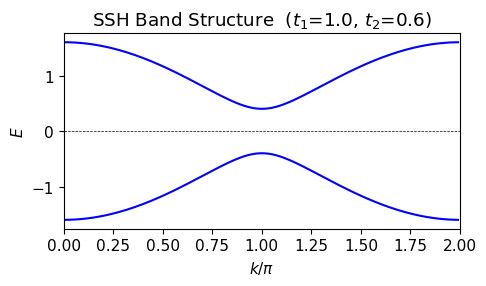

Band gap = 0.8000


In [2]:
eigvals, eigvecs = diagonalize_model(H_func, k_grid)

fig, ax = plt.subplots(figsize=(5, 3))
for n in range(2):
    ax.plot(k_grid / np.pi, eigvals[:, n], 'b-', lw=1.5)
ax.axhline(0, color='k', lw=0.5, ls='--')
ax.set_xlabel('$k / \\pi$')
ax.set_ylabel('$E$')
ax.set_title(f'SSH Band Structure  ($t_1$={t1}, $t_2$={t2})')
ax.set_xlim(0, 2)
plt.tight_layout()
plt.savefig('../docs/ssh_bands.png', dpi=100)
plt.show()
print(f'Band gap = {eigvals[:, 1].min() - eigvals[:, 0].max():.4f}')

## 3. Projection Matrix & Quantum Distance

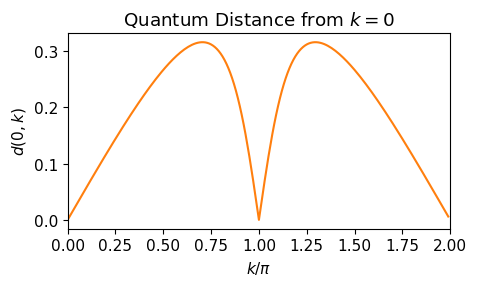

Max quantum distance = 0.3162


In [3]:
flat_bands = [0]   # lower band
P     = projection_matrix_from_vecs(eigvecs, flat_bands)
Q_mat = np.eye(2)[None, ...] - P

# Quantum distance d(k_0, k) along the BZ
d = np.array([quantum_distance(P[0], P[i], n_flat=1) for i in range(Nk)])

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(k_grid / np.pi, d, color='tab:orange')
ax.set_xlabel('$k / \\pi$')
ax.set_ylabel('$d(0, k)$')
ax.set_title('Quantum Distance from $k=0$')
ax.set_xlim(0, 2)
plt.tight_layout()
plt.show()
print(f'Max quantum distance = {d.max():.4f}')

## 4. Nestability Map  $\tilde{\omega}_0^Q$

Computes the minimum eigenvalue of $\Pi^Q$ as a function of the nesting vector $Q$.
A dip toward zero signals a preferred nesting wave vector.

Computing p-p nestability map...
Computing p-h nestability map...


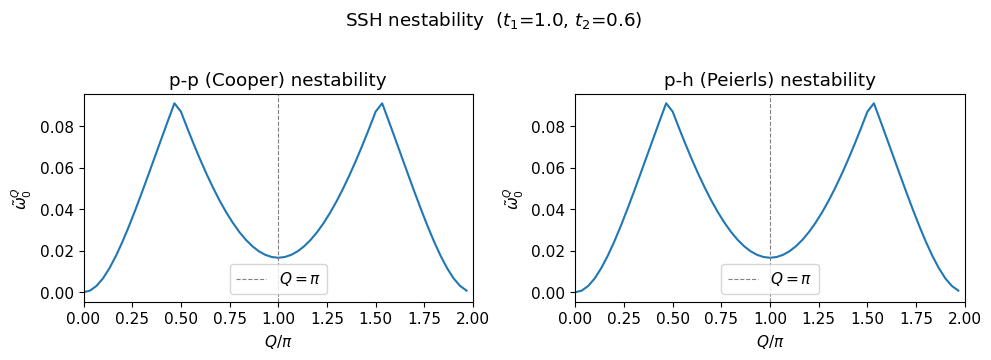

Min p-p nestability = 0.0000 at Q = 0.000
Min p-h nestability = 0.0000 at Q = 0.000


In [4]:
Q_grid = np.linspace(0, 2 * np.pi, 60, endpoint=False)

print('Computing p-p nestability map...')
omega_pp = nestability_map(P, Q_mat, k_grid, Q_grid, channel='pp')
print('Computing p-h nestability map...')
omega_ph = nestability_map(P, Q_mat, k_grid, Q_grid, channel='ph')

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
for ax, omega, label in zip(axes,
                            [omega_pp, omega_ph],
                            ['p-p (Cooper) nestability', 'p-h (Peierls) nestability']):
    ax.plot(Q_grid / np.pi, omega, color='tab:blue')
    ax.axvline(1.0, color='gray', ls='--', lw=0.8, label='$Q=\\pi$')
    ax.set_xlabel('$Q / \\pi$')
    ax.set_ylabel('$\\tilde{\\omega}_0^Q$')
    ax.set_title(label)
    ax.set_xlim(0, 2)
    ax.legend()
plt.suptitle(f'SSH nestability  ($t_1$={t1}, $t_2$={t2})', y=1.02)
plt.tight_layout()
plt.show()

print(f'Min p-p nestability = {omega_pp.min():.4f} at Q = {Q_grid[np.argmin(omega_pp)]:.3f}')
print(f'Min p-h nestability = {omega_ph.min():.4f} at Q = {Q_grid[np.argmin(omega_ph)]:.3f}')

## 5. Topological Phase Comparison

Compare nestability between trivial ($t_2 < t_1$) and topological ($t_2 > t_1$) phases.

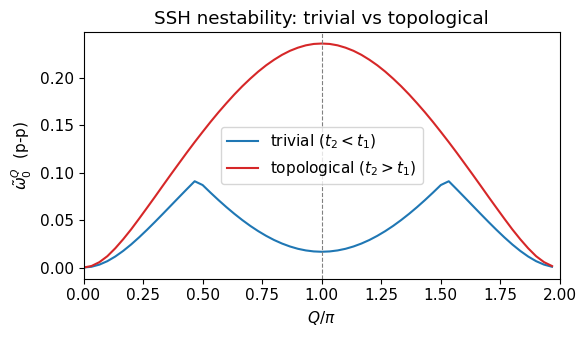

In [5]:
configs = [
    (1.0, 0.6, 'trivial ($t_2 < t_1$)'),
    (1.0, 1.4, 'topological ($t_2 > t_1$)'),
]

fig, ax = plt.subplots(figsize=(6, 3.5))
colors = ['tab:blue', 'tab:red']

for (t1c, t2c, label), color in zip(configs, colors):
    _, evecs = diagonalize_model(lambda k, t1=t1c, t2=t2c: ssh_hamiltonian(k, t1, t2), k_grid)
    Pc    = projection_matrix_from_vecs(evecs, flat_bands=[0])
    Qc    = np.eye(2)[None, ...] - Pc
    omega = nestability_map(Pc, Qc, k_grid, Q_grid, channel='pp')
    ax.plot(Q_grid / np.pi, omega, color=color, label=label)

ax.axvline(1.0, color='gray', ls='--', lw=0.8)
ax.set_xlabel('$Q / \\pi$')
ax.set_ylabel('$\\tilde{\\omega}_0^Q$  (p-p)')
ax.set_title('SSH nestability: trivial vs topological')
ax.set_xlim(0, 2)
ax.legend()
plt.tight_layout()
plt.show()

## 6. Nesting Matrix at the Minimum Q

Extract the nesting matrix $N^Q$ from the null space of $\Pi^Q$ at the most-nested $Q$.

In [6]:
Q_min_idx = np.argmin(omega_pp)
Q_min     = Q_grid[Q_min_idx]

# Use a loose tol to always get at least one nesting matrix
omega_threshold = omega_pp[Q_min_idx] * 2 + 0.05
N_list, omega_min = nesting_matrix(P, Q_mat, k_grid, Q_min, channel='pp',
                                    tol=omega_threshold)

print(f'Most-nested Q = {Q_min:.4f}  ({Q_min/np.pi:.3f}π)')
print(f'ω̃₀^Q = {omega_min:.4f}')
print(f'Number of nesting matrices: {len(N_list)}')
if N_list:
    print(f'\nNesting matrix N^Q:')
    print(np.round(N_list[0], 4))

Most-nested Q = 0.0000  (0.000π)
ω̃₀^Q = 0.0000
Number of nesting matrices: 1

Nesting matrix N^Q:
[[0.7071+0.j 0.    -0.j]
 [0.    +0.j 0.7071+0.j]]
